# Calibracion BARBOSA NSGAII

Este es un ensayo de como se puede implementar el algortimo NSGAII para la calibración de un modelo hidrológico.

In [83]:
%matplotlib inline 
import numpy as np 
import pylab as pl 
from wmf import wmf 
import pandas as pnd
# Herramientas para DEAP
from deap import base, creator
import random
from deap import tools


## Preparación cuenca para simular 

In [2]:
#Cargado de la cuenca y set
cu = wmf.SimuBasin(rute='/media/nicolas/Home/nicolas/01_SIATA/nc_cuencas/Cuenca_AMVA_Barbosa_C.nc')
wmf.models.show_storage = 1
wmf.models.separate_fluxes = 1
wmf.models.dt=300.0
#Rutas de la lluvia
ruta_lluvia = '/media/nicolas/Home/nicolas/01_SIATA/bin_rain/Barbosa60m/Barbosa60m_201702210500-201702212000.bin'
ruta_hdr = '/media/nicolas/Home/nicolas/01_SIATA/bin_rain/Barbosa60m/Barbosa60m_201702210500-201702212000.hdr'
#Nodo de evaluacion
p =np.where(wmf.models.control[wmf.models.control<>0] == 371)
nodo=p[0]
nodo = nodo+1

In [3]:
#Caudal Observado
Qaula = pnd.read_msgpack('/media/nicolas/Home/nicolas/01_SIATA/series/Q_Aula-20170221-20170222.bin')
Qaula = Qaula.rolling(window=3).median()
Qobs = Qaula['2017-02-21-15:00':'2017-02-21-21:20'].values
Qobs.shape

(77,)

Condiciones almacenamiento 

In [4]:
#Condiciones 
cu.set_Storage(wmf.models.max_capilar*0.07,0) #quiero entender esto..
cu.set_Storage(1500,3)

### Ejecución:

Calibracion : Parametros de calibracion del modelo, orden:.
            - Evaporacion.
            - Infiltracion.
            - Percolacion.
            - Perdidas.
            - Vel Superficial .
            - Vel Sub-superficial.
            - Vel Subterranea.
            - Vel Cauce.
            - Max Capilar.
            - Max Gravitacional.

# Ensayo NSGAII

Desde **wmf** se trae una nueva clase la cual es la herramienta que va a dar las ordenes a **SimuBasin** para realizar el proceso de calibración automático multi-objetivo.

A continuación se establece la cantidad de pasos, el inicio de la simulación y variables básicas para la misma, tales como:
- ruta de la lluvia binaria.
- Caudal observado con el cual se compara el algorítmo.
- el objeto de simulación **cu**.
- Los rangos aleatorios de construcción de individuos, y sus rangos de mutación.

In [70]:
#Inicip y cantidad de pasos
inicio = 125
npasos = 50
#Set del elemento
Ns = wmf.nsgaii_element(ruta_lluvia, np.roll(Qobs[5:55], -5), npasos, inicio, cu, 
    evp = [0.00001, 0.0002],
    infil = [80, 200],
    perco = [10, 50],
    losses = [0,0],
    velRun = [0.2, 3],
    velSub = [0.5, 4],
    velSup = [0.2, 0.2],
    velStream = [0.99, 0.99],
    Hu = [1,1],
    Hg = [1,1],
    rangosMutacion=[[0.00001, 0.0002], 
        [80, 200], [10, 50], [0, 0], [0.2, 3], [0.5, 4], [0.2, 0.2], [0.99, 0.99], [1.0, 1.0], [1.0, 1.0]],)
    #probCruce = [0.5, 0.2, 0.3, 1.0, 0.2, 0.2, 1.0, 1.0, 1.0],
    #probMutacion = [0.5, 0.2, 0.3, 1.0, 0.2, 0.2, 1.0, 1.0, 1.0])

A continuación se lanza el algoritmo de calibración, el caul pertenece al objeto como tal, en este se establece:
- **Ns**: El objeto con las instrucciónes para la evolución.
- **nodo**: El resultado de simulación de la cuenca que se va a tomar para evaluar al modelo.
- **pop_size**: tamano de la población.
- **process**: Cantidad de núcleos del sistema que van a ser utilizados en paralelo.
- **MUTPB**: Probabilidad genérica de mutación de un individuo.
- **CXPB**: Probabilidad genérica de cruce de dos indiviudos.

In [71]:
pop, Qsim, fit = cu.Calib_NSGAII(Ns, nodo, pop_size=40, process=20, MUTPB=0.5, CXPB=0.5)

Se presenta el resultado obtenido para las 40 realizaciones 

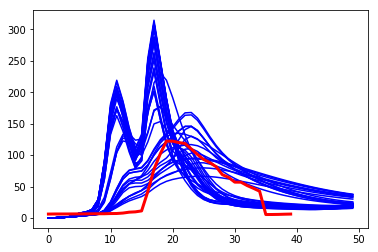

In [84]:
for i in Qsim:
    pl.plot(i, 'b')
pl.plot(np.roll(Qobs[5:45], -5), 'r', lw = 3)

**Figura 1**: Resultados de simulación (azul), vs caudal observado.

In [80]:
fit = np.array(fit).T

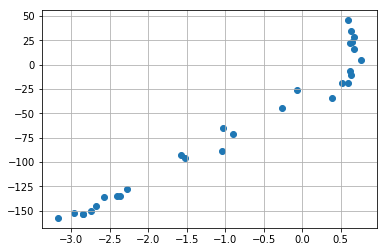

In [85]:
pl.scatter(np.array(fit).T[0],np.array(fit).T[1] )
pl.grid(True)

**Figura 2**: Superficie de pareto optimizada por el modelo de calibración.